# Generative Modelling for Financial Losses

This is an **unsupervised learning problem:**   
Given real data from stock market indexes that will act as a train dataset.  
The **task** is to learn a generative model that **simulates synthetic stock market indexes.**

## Metrics that will be mesured
- **Anderson-Darling**: How well we will fit the marginals 
- **Absolute Kendall Error**: How well we will fit the dependence structure between market indexes

Before going any further we need to be sure to understand the problem and the metrics. 

In [1]:
# The two metrics will be evaluated separately, and there will be one ranking for each metrics,
# In the following notebook I decided to manly focus on the Anderson-Darling metric.

## ANDERSON-DARLING TEST

H0 : The data follow a specified distribution.  
H1 : The data do not follow the specified distribution.

$$AD = -n - \frac{1}{n} \sum_{i=1}^n(2i-1)[(ln(F(X_i) + ln(1-F(X_{n-i+1}))]$$


where n = sample size, F(X) = cumulative distribution function for the specified distribution and i = the ith sample when the data is sorted in ascending order.  You will often see this statistic called A2.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.stats import anderson_ksamp, kendalltau
from tensorflow.keras.optimizers import Adam 
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

# Data visualisation

In [3]:
data = pd.read_csv("train1.csv", header=None)
data.drop(0,inplace=True,axis=1)
data.head()

,1,2,3,4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499


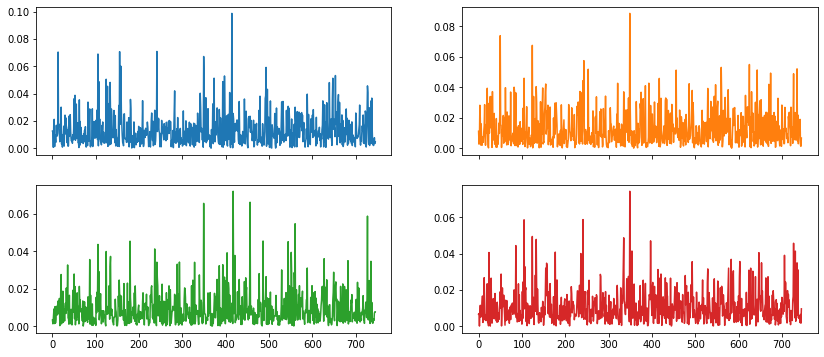

In [4]:
data.plot(subplots=True, legend=False, layout=(2,2), figsize=(14,6))
plt.show()

### Note

As we can see, all the values are **positives**, but why ? 
After asking the organizers for an explanation, we learned that: 
- Only losses have been kept
- They've taken their absolute value

That mean, the values are $|\log(P(t)) - \log(P(t-1)|$ where t is such that $log(P(t)) - log(P(t-1)) < 0$

# Reasonning. 

This is a generative modelling problem, not a prediction problem, which mean it's a bad idea to go for time series (especially when we know the time is not continuous). 

### The goal is to create fake data points that follow the same statistical law as our training set.

We can start by taking a look at the distribution of our stock indexes.

### Cumulative distribution function

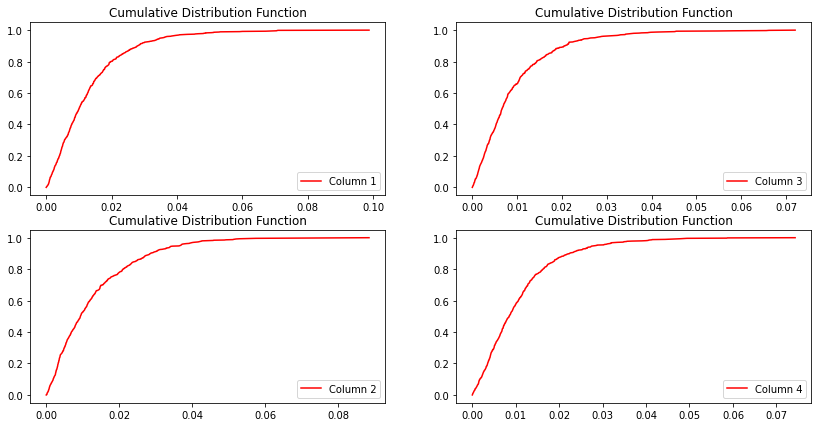

In [5]:
fig, axes = plt.subplots(2,2,figsize=(14,7))
for col_index in range(data.shape[1]):
    
    col_values = data.iloc[:,col_index]
    col_values_sorted = np.sort(col_values)
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    
    axes[col_index%2, int(col_index/2)].plot(col_values_sorted, p, color='red', label= f'Column {col_index + 1}')
    axes[col_index%2, int(col_index/2)].legend(loc=4)
    axes[col_index%2, int(col_index/2)].set_title('Cumulative Distribution Function')

## Base line 

The cumulative distribution function (CDF) of our data set looks like the CDF of the exponential law.  

To have a baseline we can try to minimize the Anderson-Darling between each column and an exponential distribution.

Let's draw random points from exponential distribution

In [6]:
def fit_expo(X):
    scores = []
    x = np.linspace(0, 250, 250)
    best_score = np.inf
    for i in x:
        expo = np.random.exponential(scale=1/i, size=len(data)) 
        score = anderson_ksamp([X,expo]).statistic
        scores.append(score)
        if score < best_score:
            best_score = score
            best_parameter = i
    return scores, best_score, best_parameter

scores, best_score, best_parameter = fit_expo(data[1])
print(best_score, best_parameter)

1.5181134166597199 66.26506024096386


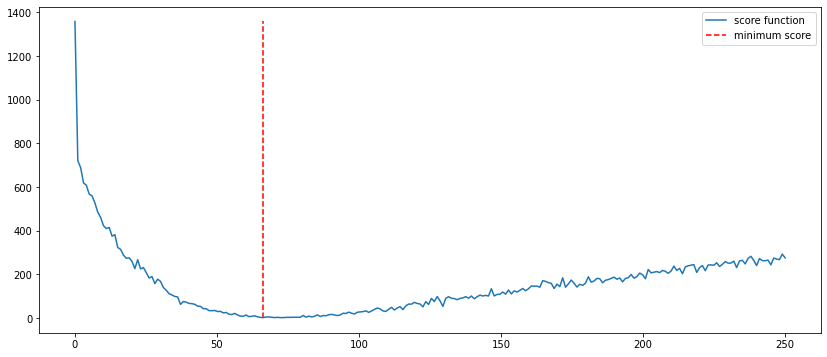

In [7]:
plt.figure(figsize=(14,6))
x = np.linspace(0, 250, 250)
plt.plot(x, scores, label="score function")
plt.vlines(best_parameter, 0, max(scores), linestyles="dashed", color ="red",label="minimum score")
plt.legend()

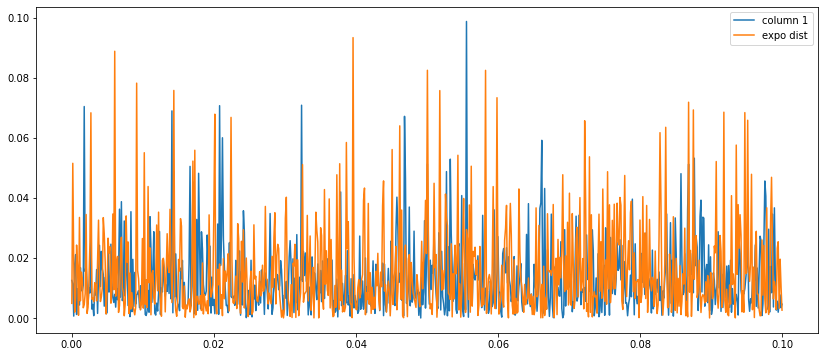

In [8]:
plt.figure(figsize=(14,6))
x = np.linspace(0, 0.1, 746)
plt.plot(x, data[1], label = "column 1")
plt.plot(x, np.random.exponential(scale=1/best_parameter, size=len(data)), label ="expo dist")
plt.legend()

We know that the CDF of the exponential is: $\large 1 - e^{-\lambda * x}$  
We can plot the CDF of the exponential and the CDF of our data set for each column

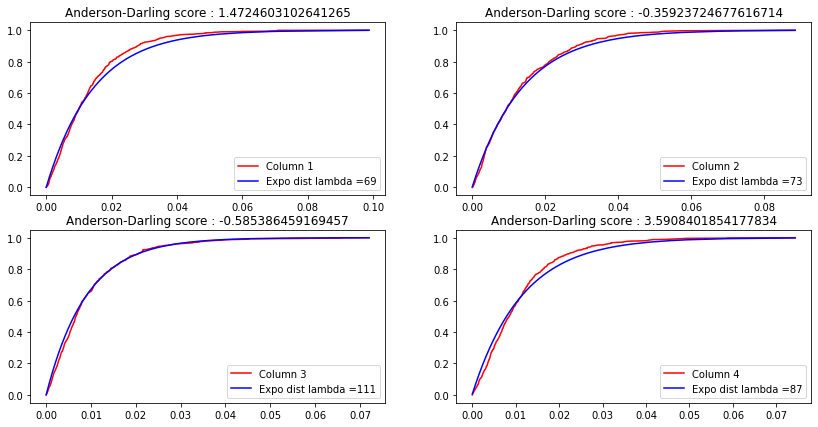

In [11]:
fig, axes = plt.subplots(2,2,figsize=(14,7))
baseline = []
for i in range(4):
    column_i = data[i+1]
    scores, best_score, best_parameter = fit_expo(column_i)
    # sort the data:
    column_i_sorted = np.sort(column_i)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(column_i)) / (len(column_i) - 1)

    axes[int(i/2),i%2].plot(column_i_sorted, p, color="red", label=f"Column {i+1}")
    axes[int(i/2),i%2].plot(column_i_sorted, 1 - np.exp(-best_parameter*column_i_sorted), 
                            color="blue", label=f"Expo dist lambda ={round(best_parameter)}")
    axes[int(i/2),i%2].legend(loc=4)
    axes[int(i/2),i%2].set_title(f"Anderson-Darling score : {best_score}")
    baseline.append(best_score)
plt.show()

In [12]:
baseline

[1.4724603102641265,
 -0.35923724677616714,
 -0.585386459169457,
 3.5908401854177834]

# Generative Adversarial Networks (GANs)

We will try to fit a GAN model to our dataset.   
At some epoch, we will print the Anderson-Darling score and the CDF of the dataset, the fake data, and our baseline. 

The last layer of the generator is composed of 4 neurons since we are prediction 4 values each times.

In [14]:
codings_size = 4

In [15]:
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(4 * 1, activation="sigmoid"),
    keras.layers.Reshape([4, 1])])
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 604       
_________________________________________________________________
reshape (Reshape)            (None, 4, 1)              0         
Total params: 26,354
Trainable params: 26,354
Non-trainable params: 0
_________________________________________________________________


The discriminator will take row of the data set as input, as well as fake data.  
Hence the input_shape is [4,1]

In [16]:
discriminator = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[4, 1]),    
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(150, activation="selu"), 
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(1, activation="sigmoid")])

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               750       
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 38,601
Trainable params: 38,601
Non-trainable params: 0
_________________________________________________________________


## Training

Since we only want to generate good values, we are not interested in the discriminator's ability to generalize its task, therefore we can train the gan on the whole training dataset.   
If the gan did a good job we will see it through the plots and the Anderson-Darling value.

On the second week on the tournament, the organizator will give us the validation data set they used to compare our scores. 

In [18]:
def train_gan(data, batch_size, codings_size, n_epochs=50, nb_plots=10):
    
    
    X_train = np.array(data).reshape(746,4,1)
    X_train = tf.cast(X_train, tf.float32) 
    dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


    generator = keras.models.Sequential([
        keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
        keras.layers.Dense(100, activation="selu", input_shape=[codings_size]), 
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(4 * 1, activation="sigmoid"),
        keras.layers.Reshape([4, 1])
    ])

    discriminator = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[4, 1]),    
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(150, activation="selu"), 
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    
    gan = keras.models.Sequential([generator, discriminator])
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    
    # The discriminator is a binary classifier so we can use the binary_crossentropy as loss.
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop") 
    discriminator.trainable = False
    
    # The gan is a binary classifier so we can use the binary_crossentropy as loss.
    gan.compile(loss="binary_crossentropy", optimizer=opt)
    
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        
        for X_batch in dataset:
            
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
        # some plots
        if (epoch + 1) % (n_epochs/nb_plots) == 0 :
            print("Epoch {}/{}".format(epoch + 1, n_epochs)) 
            
            fig, axes = plt.subplots(2,2,figsize=(14,7))
            for i in range(4):
                axes[int(i/2),i%2].plot(X_batch[:,0], color='red', label = "True")
                axes[int(i/2),i%2].plot(generated_images[:,0], color='blue', label = "Fake")
                axes[int(i/2),i%2].legend(loc=1)
            plt.show()
            
            fig, axes = plt.subplots(2,2,figsize=(14,7))

            for i in range(4):
                values = [72,75,105,86] # hand coded to avoid some computation
                data1 = data[i+1]
                data_sorted = np.sort(data1)
                p = 1. * np.arange(len(data1)) / (len(data1) - 1)

                axes[int(i/2),i%2].plot(data_sorted, p, color="red", label="dataset")
                axes[int(i/2),i%2].plot(data_sorted, 1 - np.exp(-values[i]*data_sorted), color="blue", label="Expo dist")

                #adding the cdf of the fake values 
                data2 = [float(generated_images[j][i]) for j in range(len(generated_images))]
                data_sorted = np.sort(data2)
                p = 1. * np.arange(len(data2)) / (len(data2) - 1)
                axes[int(i/2),i%2].plot(data_sorted, p, color="green", label="Fake data")

                axes[int(i/2),i%2].legend(loc=4)
            plt.show()
            
            print(anderson_ksamp([data[1], [float(ele) for ele in generated_images[:,0]]]).statistic,
                  anderson_ksamp([data[2], [float(ele) for ele in generated_images[:,1]]]).statistic,
                  anderson_ksamp([data[3], [float(ele) for ele in generated_images[:,2]]]).statistic,
                  anderson_ksamp([data[4], [float(ele) for ele in generated_images[:,3]]]).statistic)
            
    # Save the model
    #generator.save_weights('model_weights.h5')
    # Once it's trained, we return 410 points
    noise = tf.random.normal(shape=[410, codings_size])
    #np.savetxt('noise.csv', np.array(noise), delimiter=',', fmt='%s')
    
    generated_data = generator(noise)
    generated_data = np.reshape(generated_data, (410, 4)) # reshape data 
    #np.savetxt('generated_samples.csv', np.array(generated_data), delimiter=',', fmt='%s')
    
    return generator

Epoch 100/100


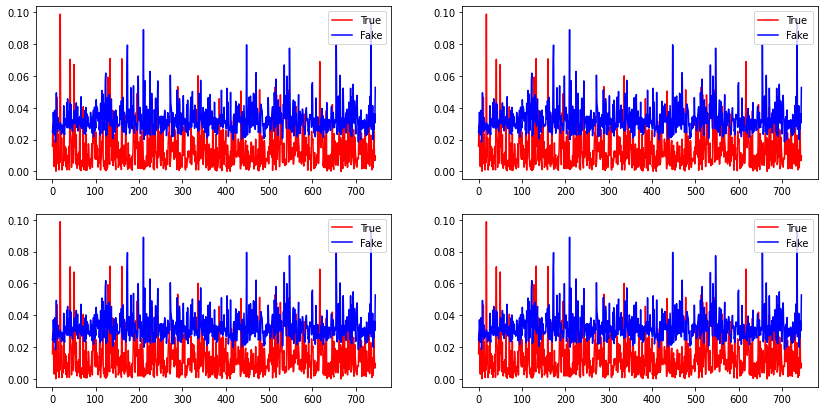

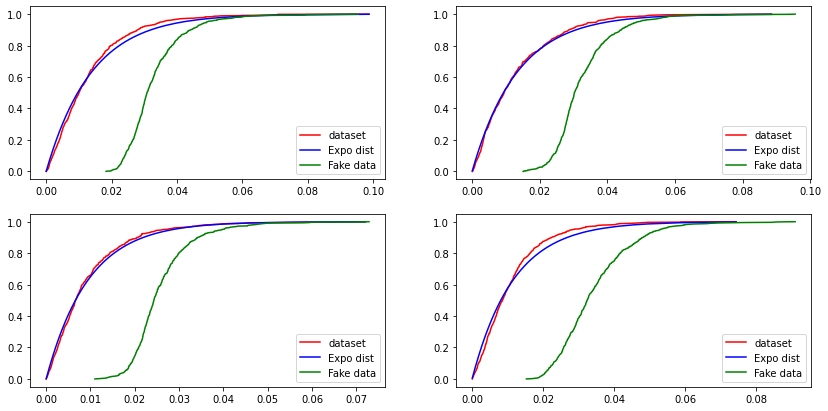

542.2503435390645 516.2136744716795 570.6524129360789 627.6376322158206


In [19]:
codings_size = 4
batch_size = len(data)

generated_images_1 = train_gan(data, batch_size, codings_size, n_epochs=100, nb_plots=1) 

We can see that on a 100 hundred epoch the model is really poor. The data isn't fitted at all, let's train it for a higher number of epoch.

Epoch 1000/6000


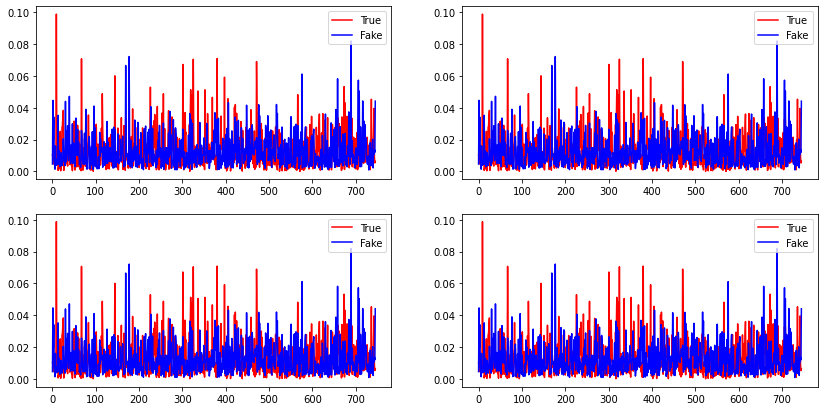

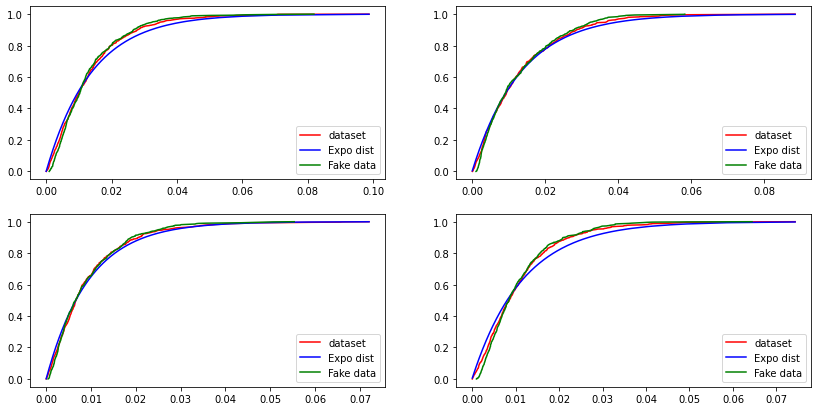

3.037190259275492 2.3305079385399377 1.0643908041592434 4.078888613177248
Epoch 2000/6000


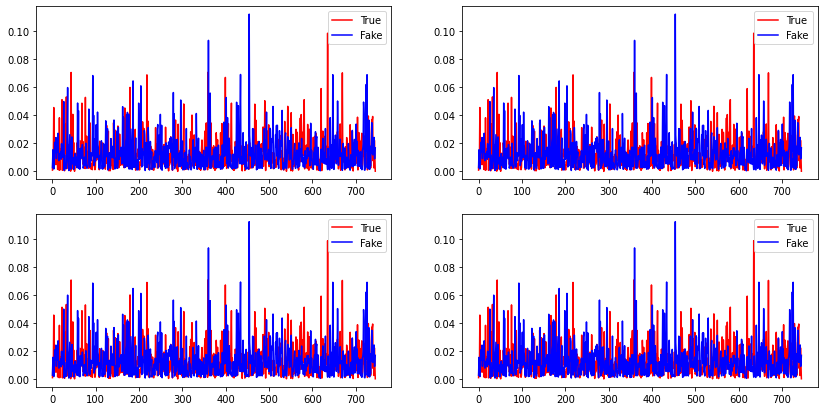

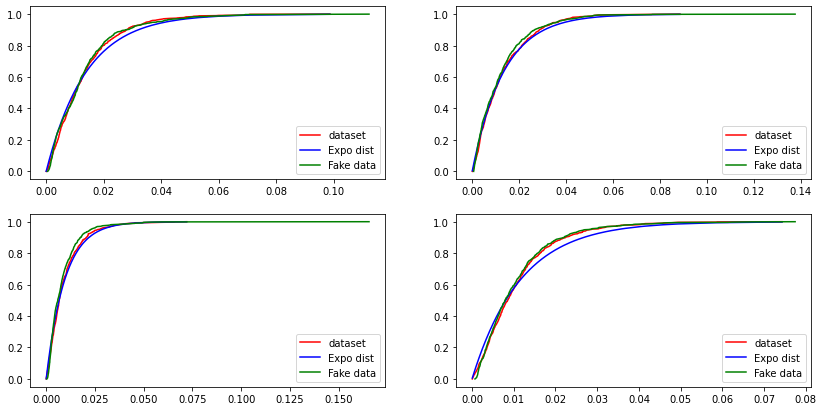

0.7101918745365953 1.1065150545462237 4.950891400178475 0.858306555198946
Epoch 3000/6000


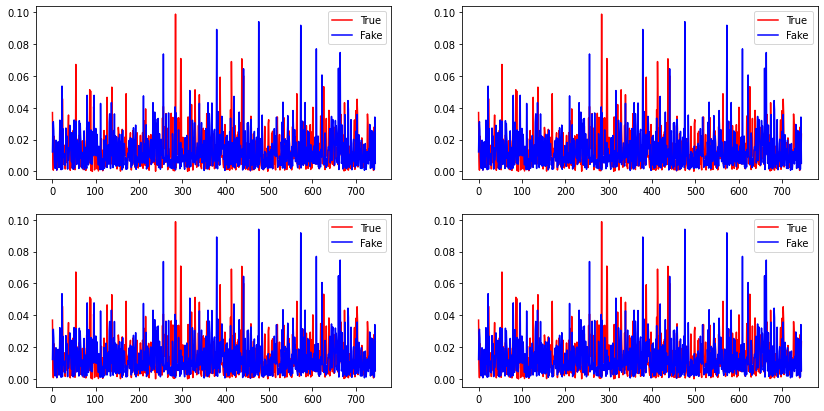

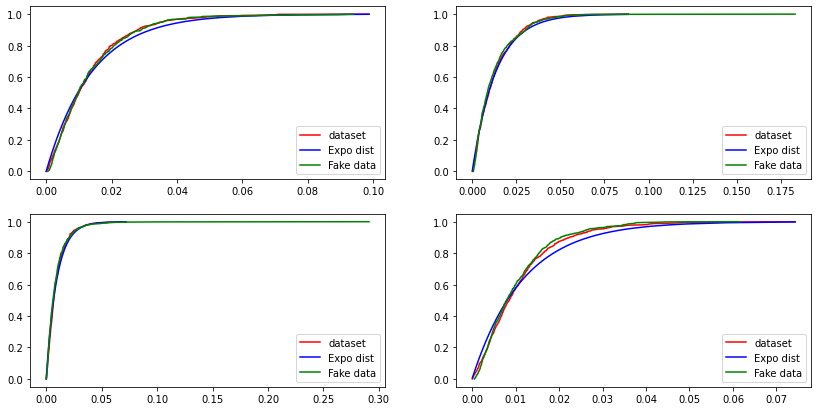

0.14185103071870694 0.7885339942675447 1.4103231495343294 0.8885328122199008
Epoch 4000/6000


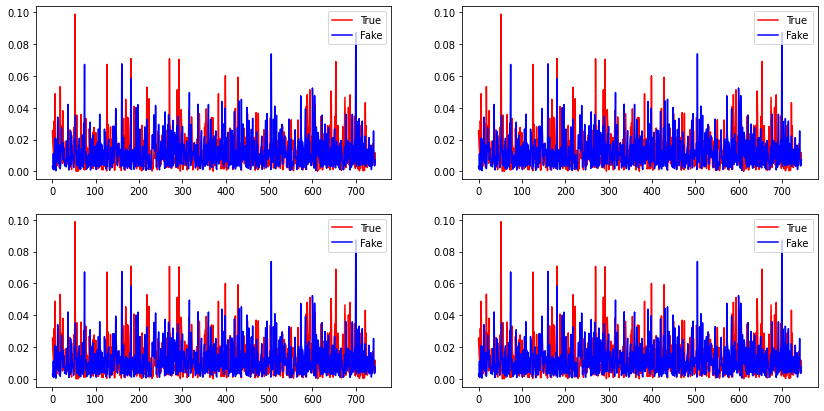

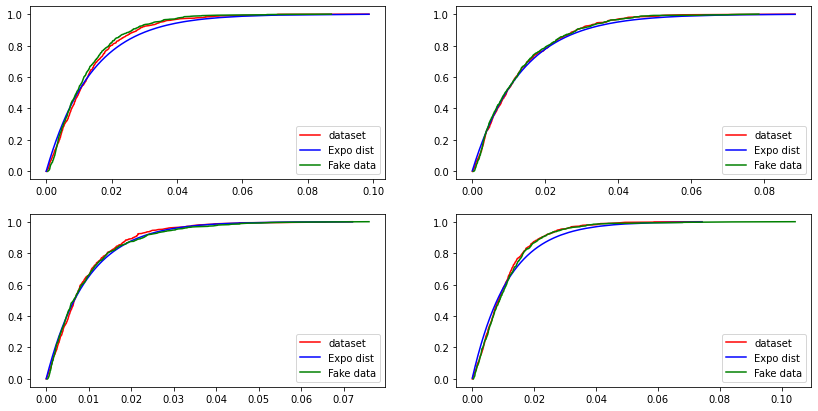

1.3359826394618148 -0.3914385426242007 0.53676375361684 -0.321443592392674
Epoch 5000/6000


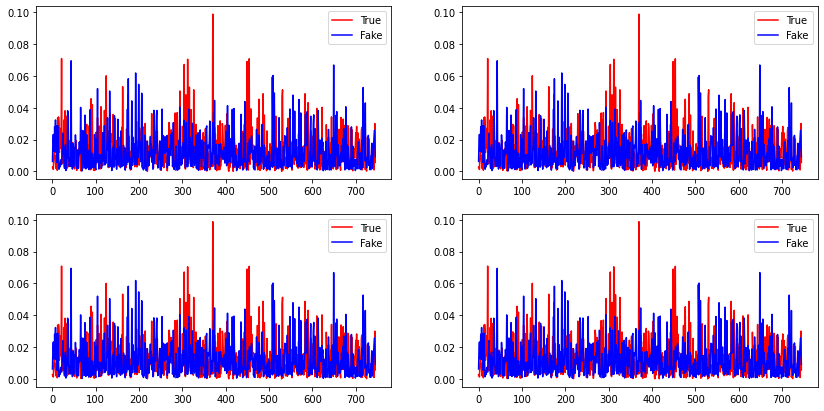

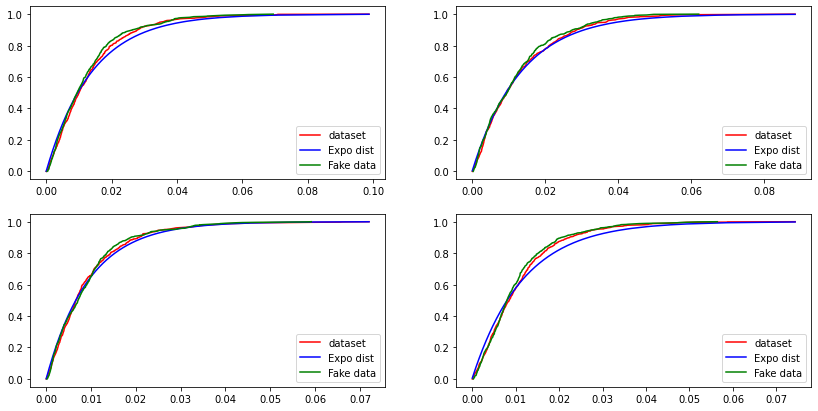

0.37891774479213275 0.140943385164046 0.2798758056372997 0.30521761508551476
Epoch 6000/6000


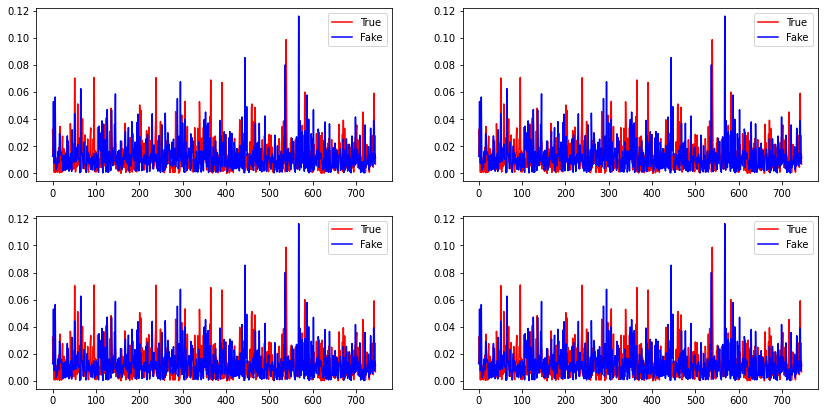

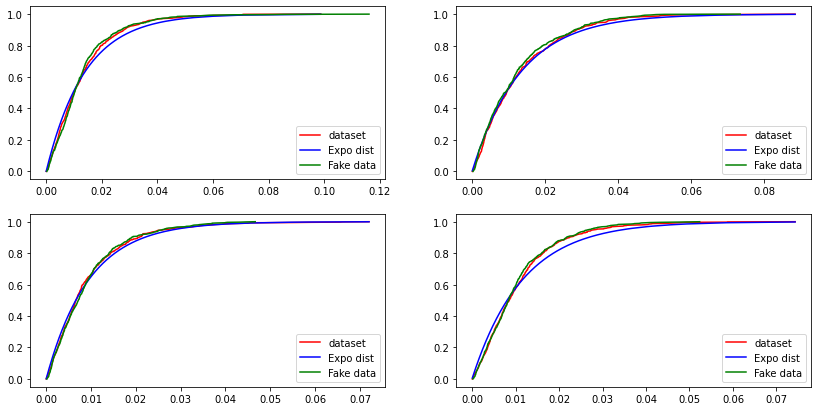

-0.0066085495723832875 0.3121180625754955 -0.28066473697627176 -0.4569034889348597


In [20]:
generated_images_2 = train_gan(data, batch_size, codings_size, n_epochs=6000, nb_plots=6) 

It is definitely better ! The CDF looks very similar and it's confirmed with a low Anderson-Darling value

In [23]:
scores = []
for _ in range(200):
    score= [anderson_ksamp(
        [data[i+1], np.reshape(generated_images_2(tf.random.normal(shape=[410, codings_size])), 
                    (410,4))[:,i]]).statistic for i in range(4)]
    scores.append(score)
    
scores = np.array(scores)

In [24]:
[np.mean(np.abs(scores[:,i])) for i in range(4)]

[0.5836928943178611,
 0.5328779288585126,
 0.4978740870503634,
 0.7197907271536937]

##### Validation Data set

In [ ]:
test_data = pd.read_csv("data_val_log_return.csv", header = None)
test_data.drop(0,inplace=True,axis=1)
test_data.head()

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(14,7))
axes[0,0].plot(test_data[1], color='red', label = "True")
axes[0,0].plot(generated_images_1[:,0], color='blue', label = "Fake")
axes[0,0].legend(loc=1)

axes[0,1].plot(test_data[2], color='red', label = "True")
axes[0,1].plot(generated_images_1[:,1], color='blue', label = "Fake")
axes[0,1].legend(loc=1)

axes[1,0].plot(test_data[3], color='red', label = "True")
axes[1,0].plot(generated_images_1[:,2], color='blue', label = "Fake")
axes[1,0].legend(loc=1)

axes[1,1].plot(test_data[4], color='red', label = "True")
axes[1,1].plot(generated_images_1[:,3], color='blue', label = "Fake")
axes[1,1].legend(loc=1)
plt.show()

fig, axes = plt.subplots(2,2,figsize=(14,7))
for i in range(4):
    values = [72,75,105,86] # value obtained with training on data set 1 

    data = test_data[i+1]
    # sort the data:
    data_sorted = np.sort(data)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(data)) / (len(data) - 1)

    axes[int(i/2),i%2].plot(data_sorted, p, color="red", label="validation_dataset")
    axes[int(i/2),i%2].plot(data_sorted, 1 - np.exp(-values[i]*data_sorted), color="blue", label="Expo dist")


    # same to add the cdf of the fake values 
    data = [float(generated_images_1[j][i]) for j in range(len(generated_images_1))]
    data_sorted = np.sort(data)
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    axes[int(i/2),i%2].plot(data_sorted, p, color="green", label="generated_images")

    axes[int(i/2),i%2].legend(loc=4)
plt.show()

for i in range(4):
    x1 = test_data[i+1]
    x2 = [float(ele) for ele in generated_images_1[:,i]]
    print(anderson_ksamp([x1, x2]))

# Old model results
Anderson_ksampResult(statistic=0.5079657656785598, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.20490286969640048)  
Anderson_ksampResult(statistic=0.9503303152630564, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.1327240198655571)  
Anderson_ksampResult(statistic=5.997223622925653, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.0015495275486764268)  
Anderson_ksampResult(statistic=2.1030385045009323, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.04426222997505082)  

## New model results (better than old model)

Anderson_ksampResult(statistic=0.3427414127868876, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.24142569937662556)  
Anderson_ksampResult(statistic=-0.4548220038287272, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)  
Anderson_ksampResult(statistic=-0.35631325957466536, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)  
Anderson_ksampResult(statistic=-0.45012853046335294, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)  

# Data set augmentation

If we augment the size of our data set it's likely we will have a better model.   
It will catpure less noise which is good for generalization.

Augmentation of the data by combining the two data set 
- training data set
- validation data set

Once the structure of the model and it's hyperparameters are well set we can use the validation set in the training data as well.

In [ ]:
full_data = pd.concat([data1,test_data])
full_data.head()

In [ ]:
codings_size = 4
batch_size = len(full_data)
batch_size = batch_size

X_train = np.array(full_data).reshape(len(full_data),4,1)
X_train = tf.cast(X_train, tf.float32)
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

generated_images_2 = train_gan(dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
for i in range(4):
    x1 = full_data[i+1]
    x2 = [float(ele) for ele in generated_images_2[:,i]]
    print(anderson_ksamp([x1, x2]))

The model trained on a bigger dataset output really good results. 

### Kendall metrics

In [ ]:
full_data

In [ ]:
full_data.iloc[np.random.randint(0,len(full_data),410)]

In [ ]:
print(kendalltau(full_data.iloc[np.random.randint(0,len(full_data),410)],generated_images_1))
print(kendalltau(full_data.iloc[np.random.randint(0,len(full_data),410)],generated_images_2))

In [ ]:
# reshape data 
generated_data = np.reshape(generated_images_2, (410, 4))
np.savetxt('generated_samples.csv', np.array(generated_data), delimiter=',', fmt='%s')